In [139]:
import logging
import sys
import MySQLdb
import dbconn2
import csv
import math
import itertools
from datetime import datetime, timedelta,date
import dateparser
import decimal     # some MySQL types are returned as type decimal
from dbi import get_dsn, get_conn # connect to the database
import date_ui
import numpy as np
import json
from typing import Optional
import pandas as pd
import argparse

import plotly.express as px
from plotly.subplots import make_subplots

import plotly.graph_objects as go


In [140]:
def get_data_records(curs, table = "nudge_isf_results") -> list:
    """ Query ICS2 and nudge_isf_results for graph data)"""
    curs.execute(f''' 
        SELECT ics2.rtime, ics2.cgm, ics2.dynamic_insulin, ics2.dynamic_carbs, nisf.clean_5_min_yrly_basal, nisf.clean_15_min_yrly_basal, nisf.clean_30_min_yrly_basal, nisf.clean_2_hr_yrly_basal
        FROM insulin_carb_smoothed_2 as ics2
        LEFT JOIN nudge_isf_results_avg as nisf
        ON ics2.rtime = nisf.rtime
        WHERE ics2.rtime >= "2024-09-01"; 
    ''')
    
    ics2_records = curs.fetchall()
    return ics2_records


In [141]:
def main(): 
    conn = get_conn()
    curs = conn.cursor()

    records = get_data_records(curs, table = "nudge_isf_results_avg")
    df = pd.DataFrame(records, columns =['rtime', 'cgm', 'di', 'dc', '5min', '15min', '30min', '2hr'])

    return df
    

In [142]:
df = main()
df = df.sort_values(by = "rtime")
df["30min_avg"] = df["30min"].rolling(6).mean()
df["2hr_avg"] = df["2hr"].rolling(6).mean()
df.shape

(10251, 10)

In [143]:
df.head(20)

,rtime,cgm,di,dc,5min,15min,30min,2hr,30min_avg,2hr_avg
0,2024-09-01 00:00:00,109.0,0.410171,1.422750,0.000000,-1.46754,-2.345850,-3.763840,NaN,NaN
1,2024-09-01 00:05:00,109.0,0.406088,1.378540,-2.083990,-3.19031,-3.479330,-4.144550,NaN,NaN
2,2024-09-01 00:10:00,112.0,0.393022,1.317910,-1.417950,-2.75523,-3.438270,-3.968270,NaN,NaN
3,2024-09-01 00:15:00,114.0,0.391558,1.241980,-2.891330,-2.66163,-3.651620,-3.989000,NaN,NaN
4,2024-09-01 00:20:00,118.0,0.379504,1.152270,0.000000,-1.69147,-2.604990,-3.622470,NaN,NaN
5,2024-09-01 00:25:00,118.0,0.344243,1.050590,-0.821464,-3.90832,-3.071370,-3.812470,-3.098572,-3.883433
6,2024-09-01 00:30:00,119.0,0.343765,0.939104,-4.859600,-5.14352,-2.859760,-3.792070,-3.184223,-3.888138
7,2024-09-01 00:35:00,125.0,0.352908,0.820313,-2.411350,-1.37628,0.079278,-2.871640,-2.591122,-3.675987
8,2024-09-01 00:40:00,128.0,0.348488,0.697049,0.862194,1.89108,1.337500,-2.418660,-1.795160,-3.417718
9,2024-09-01 00:45:00,127.0,0.310766,0.572478,0.913785,2.40117,0.175210,-2.647690,-1.157355,-3.194167


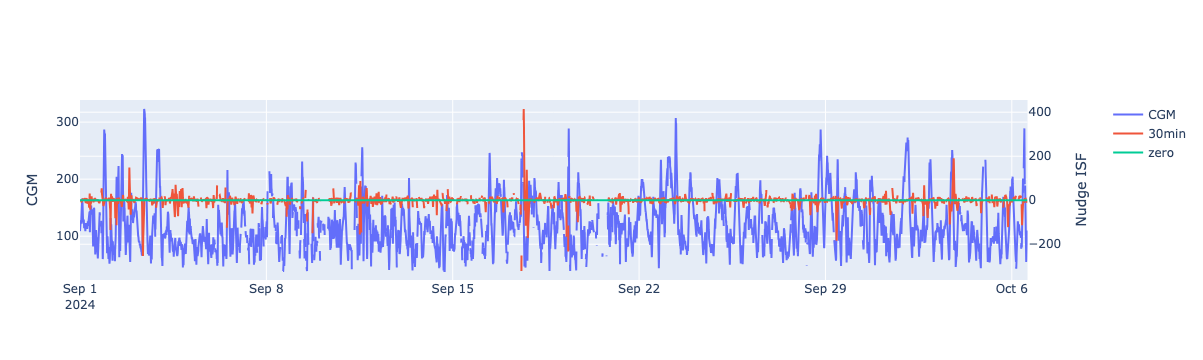

In [161]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(
    x=df.rtime,
    y=df.cgm,
    name = 'CGM', # Style name/legend entry with html tags
), secondary_y = False)
# fig.add_trace(go.Scatter(
#     x=df.rtime,
#     y=df.di,
#     name = 'DI', # Style name/legend entry with html tags
#     ), 
#               secondary_y = True)
# fig.add_trace(go.Scatter(
#     x=df.rtime,
#     y=df.dc,
#     name = 'DC', # Style name/legend entry with html tags
# ), 
#              secondary_y = True)
fig.add_trace(go.Scatter(
    x=df.rtime,
    y=df["30min_avg"],
    name = '30min', # Style name/legend entry with html tags
), secondary_y = True)
fig.add_trace(go.Scatter(
    x=df.rtime,
    y=np.zeros(len(df.rtime)),
    name = 'zero' # Style name/legend entry with html tags
), secondary_y = True)
fig.update_yaxes(title_text="CGM", secondary_y=False)
fig.update_yaxes(title_text="Nudge ISF", secondary_y=True)

fig.show(width = 10, height = 10)